# Image Classification with TensorFlow, Keras & OpenCV | FGG

## Setting Up and Loading Data

### 1. Set up and installing dependencies

In [ ]:
!pip install opencv-python

In [ ]:
!pip install matplotlib

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoiding OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
gpus = tf.config.list_physical_devices('GPU')

In [6]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2. Removing unwanted images & cleaning data

In [7]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [8]:
data_dir = 'data'

In [9]:
os.listdir(data_dir)

['happy', '.DS_Store', 'sad']

In [10]:
image_exts = ['jpeg','jpg','bmp','png']

In [11]:
image_exts[2]

'bmp'

In [12]:
img = cv2.imread(os.path.join('data', 'happy', 'pexels-photo-1999504.jpeg'))

In [13]:
img.shape

(6000, 4000, 3)

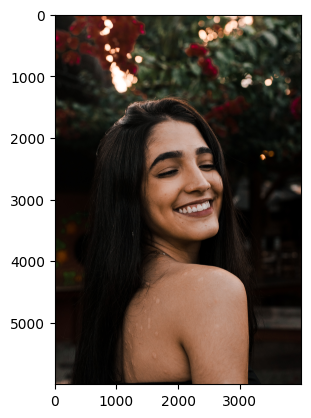

In [14]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

### 3. Loading Data

In [16]:
import numpy as np

In [18]:
# Building our Data Pipeline
data = tf.keras.utils.image_dataset_from_directory('data')

Found 350 files belonging to 2 classes.


In [19]:
# Accessing the Data Pipeline
data_iterator = data.as_numpy_iterator()

In [21]:
# Getting another batch of images from the iterator
batch = data_iterator.next()

In [22]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [23]:
# Class 1 = Sad people
# Class 0 = Happy people
batch[1]

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0], dtype=int32)

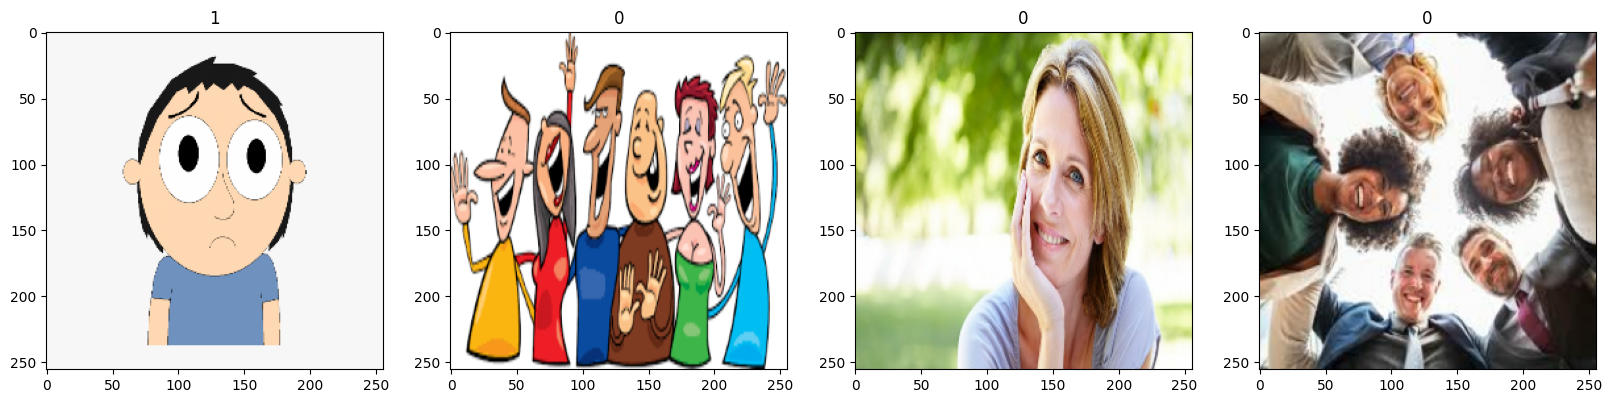

In [24]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Preprocess Data

### 1. Scaling Data

In [25]:
data = data.map(lambda x, y: (x/255, y))

In [26]:
scaled_iterator = data.as_numpy_iterator()

In [27]:
batch = scaled_iterator.next()

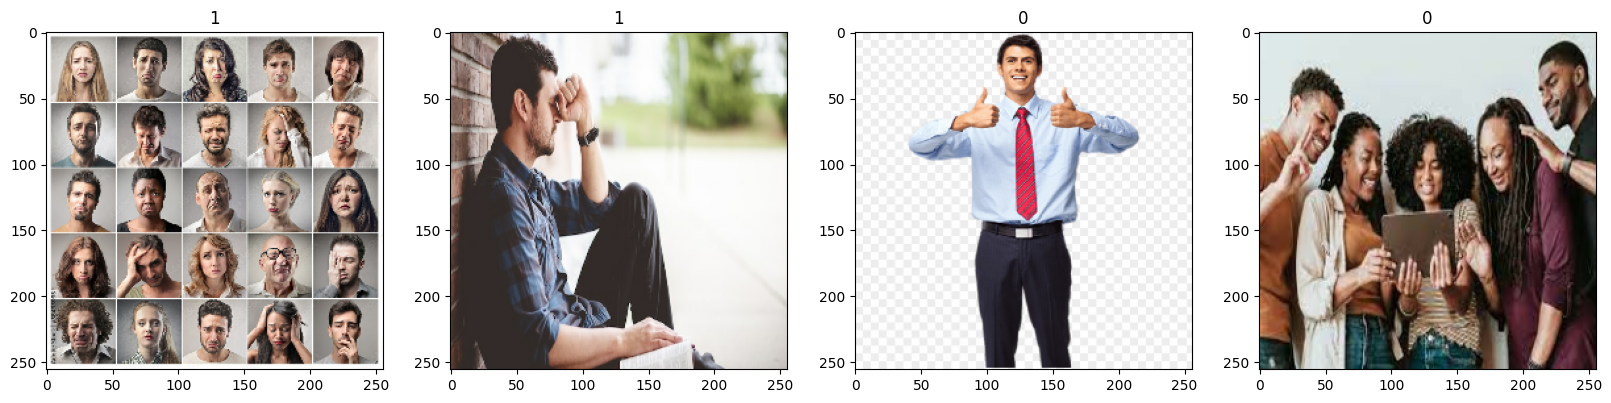

In [28]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

### 2. Splitting Data

In [29]:
len(data)

11

In [30]:
train_size = int(len(data)*.7)-1
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [31]:
train = data.take(train_size) # how many batches we want to allocate to our training data
val = data.skip(train_size).take(val_size) # Skip the batches that we've already allocated to our training partition and then take the val data.
test = data.skip(train_size+val_size).take(test_size) # Skip training data and val data, and then take the test partition.

In [32]:
len(train)

6

## Deep Learning Model

### 1. Building Deep Learning Model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [34]:
model = Sequential()

In [35]:
# These two lines are adding a convolutional layer and a max pooling layer
# 16 filters, 3px by 3px in size, stride of 1 -> It's going to move one pixel each time

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3))) # changing these paremeters will change how the model performs
model.add(MaxPooling2D()) # This takes the maximum value after the relu activation and return back that value

model.add(Conv2D(32, (3,3), 1, activation='relu')) # 32 filters
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten()) # 

# These are the fully connected layers

model.add(Dense(256, activation='relu')) 
model.add(Dense(1, activation='sigmoid')) # A sigmoid activation takes any output and converts it into a range between 0 and 1

In [36]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy']) # Using adam optimizer

In [ ]:
model.summary()

### 2. Training the Model

In [38]:
logdir = 'logs'

In [39]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# model.fit is the training component, model.predict when predictions are carried out
# epochs is how long we are going to train our data, 1 epoch = 1 run over the entire set of data

hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

### 3. Plotting Model Performance

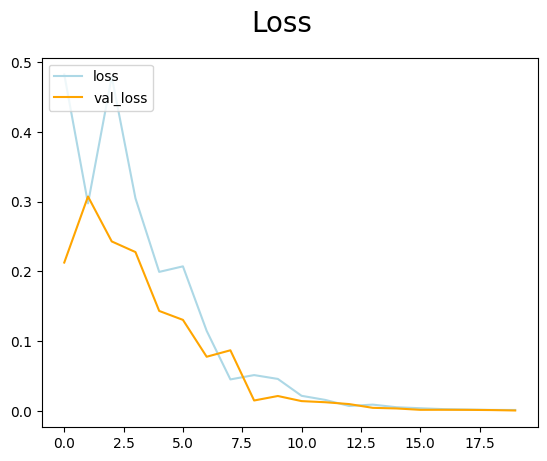

In [97]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='lightblue', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

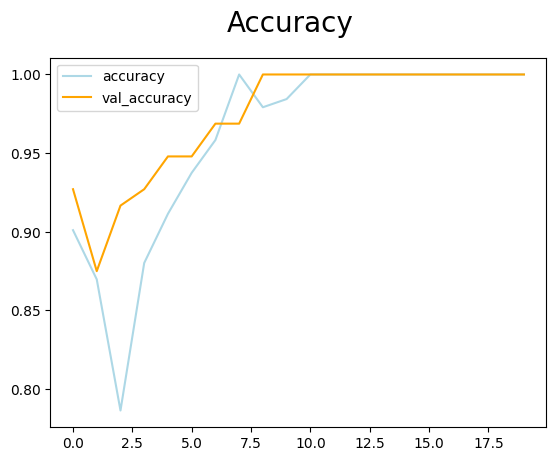

In [98]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='lightblue', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Evaluating Performance

### 1. Evaluating

In [99]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [100]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [101]:
len(test)

2

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [103]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


### 2. Testing with images that are not in dataset

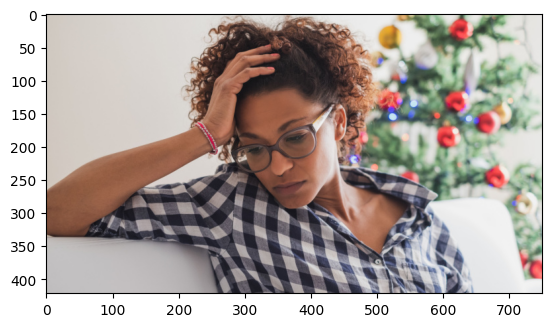

In [119]:
img = cv2.imread('sadtest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


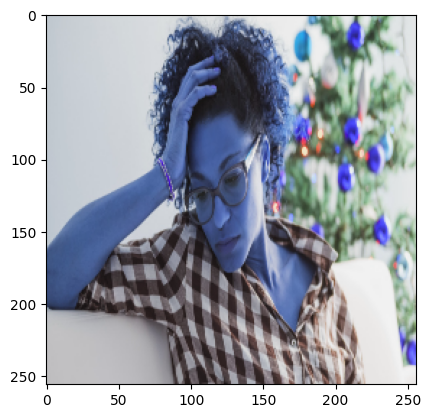

In [120]:
# Our Deep Learning Model only understands 256x256 pictures
# We therefore resize the new test image

resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [121]:
resize.shape

TensorShape([256, 256, 3])

In [122]:
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [123]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 15ms/step


In [124]:
yhat

array([[0.8364602]], dtype=float32)

In [125]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


## Saving the Model

### 1. Save Model

In [126]:
from tensorflow.keras.models import load_model

In [127]:
model.save(os.path.join('models', 'fgg_happy_sad_model.h5'))

In [132]:
# Here I'm re-launching the model to check that it can be used at a later date

new_model = load_model(os.path.join('models', 'fgg_happy_sad_model.h5'))

In [130]:
yhat_new = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 13ms/step


In [131]:
if yhat_new > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')
    

Predicted class is Sad
